In [1]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
from urllib.parse import urlparse, urljoin, quote
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'png'
import numpy as np
from matplotlib.ticker import FuncFormatter
import requests
import scipy.stats as sps
import io
import openai
import timeout_decorator
from collections import Counter




# enable horizontal scroll of data frame in Jupyter lab
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

pd.options.display.html.use_mathjax = False
pd.options.display.min_rows = 100
pd.options.display.max_rows = 100


# Part A: Download all of electionline weekly

In [220]:
YEARS = reversed(range(2011, 2024))

# Define user-agent to simulate a web browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

base_url = 'https://electionline.org'

for year in YEARS:
    dir_path = f"electionline-weekly/{year}"
    os.makedirs(dir_path, exist_ok=True)
    
    url = f"{base_url}/electionline-weekly/{year}"
    
    # Send an HTTP GET request with headers
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.text, 'html.parser')
    
    weeks = soup.find('ul', class_='weeks').find_all('li')
    weeks = [f"{base_url}{week.find('a')['href']}" for week in weeks]

    for week in weeks:
        response = requests.get(week, headers=headers)
        with open(f"{week.split('electionline.org/')[-1]}.html", 'w') as f:
            f.write(response.text)


# Part B: Manual scraping with regex

Go through all the saved HTML, and make each paragraph a row in a pandas data frame. Use regex to pull out key details.

In [2]:
YEARS = reversed(range(2011, 2024))

job_df = pd.DataFrame()

for year in YEARS:
    dir = f"electionline-weekly/{year}"
    weeks = os.listdir(dir)

    for week in weeks:
        date = week[:5]
        
        with open(os.path.join(dir, week)) as f:
            text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
    
        # Find all divs with the class 'article-wrapper'
        divs_with_class = soup.find_all('div', class_='article-wrapper')
    
    
        for div in divs_with_class:
            h2_tags = div.find_all('h2', string=re.compile(r'^job', re.I))
            
            if h2_tags:
                for h2_tag in h2_tags:
                    # Find all p elements within the div containing the matched h2 tag
                    # Skip the first paragraph
                    job_paragraphs = div.find_all('p')[1:]  

                    # Skip intro and empty paragraphs
                    job_paragraphs = [para for para in job_paragraphs if (not para.text.startswith('electionlineWeekly')) and (len(para.text)>10)]    
                    
                    for paragraph in job_paragraphs:
                        # Extract job information from the paragraph
                        link = paragraph.find('a')
                        job_title = link.get_text() if link is not None else ""
                        
                        employer_match = re.search(r'\/a>[^,]*(?:,|-)\s*([^-–—]*)', str(paragraph))
                        employer = employer_match.group(1) if employer_match else ""
                        
                        # salary_match = re.search(r'Salary[^:]*:\s(.*?)(?=\.\s)', paragraph.get_text())
                        salary_match = re.search(r'Salary[^:]*:\s(.*?)(?=\.\s|Dead)', paragraph.get_text())
                        salary = salary_match.group(1) if salary_match else ""
                        
                        description = paragraph.get_text()
                        job_link = link['href'] if link is not None else ""
    
                        # Append job information to the list as a dictionary
                        new_row = pd.DataFrame({'Job Title': job_title,
                                                'Employer': employer,
                                                'Salary': salary,
                                                'Description': description,
                                                'Link': job_link,
                                                'Date': date,
                                                'Year': year}, index=[0])
                        job_df = pd.concat([job_df, new_row], ignore_index=True)

# some cleanup!

job_df = job_df.drop_duplicates(subset=['Job Title', 'Employer', 'Salary', 'Link'], keep='last')

# exclude listings from some of the top URLs belonging to private employers
excluded_domains = ['dominionvoting.com',
                   'clearballot.com',
                   'electioninnovation.org',
                   'runbeck.net',
                   'rockthevote.com',
                   'hartintercivic.com',
                   'fordfoundation.org',
                   'techandciviclife.org',
                   'bipartisanpolicy.org',
                   'cdt.org',
                   'ericstates.org',
                   'centerfortechandciviclife.recruitee.com',
                   'democracy.works',
                   'electionreformers.org',
                   'verifiedvoting.org']

def is_not_excluded_domain(url):
    netloc = urlparse(url).netloc.replace('www.', '')
    return netloc not in excluded_domains

job_df = job_df[job_df['Link'].apply(is_not_excluded_domain)]

def pay_basis(x):
    x = x.lower()
    if re.search('hr|hour', x):
        return 'hourly'
    elif re.search('month', x):
        return 'monthly'
    elif re.search('biweek', x):
        return 'biweekly'
    elif re.search('week', x):
        return 'weekly'
    else:
        return 'yearly'

job_df['Pay basis'] = job_df['Salary'].apply(pay_basis)

 # just a guess to correct the typo. It could be 110, or 101,... not sure.
job_df.loc[(job_df['Job Title']=='Elections Manager') & (job_df['Employer'] == 'Anoka County, Minnesota'), 'Salary']='$88,628-$101,878'

def clean_salary(x):
    cleaned_string = x.replace(' to ', '-').replace(' and ', '-')
    cleaned_string = cleaned_string.replace('Grade 14-', '')
    cleaned_string = re.sub(f'[^0-9\.\-–—]', '', cleaned_string) # get rid of things that aren't dashes and hyphens, periods, en, or em dashes.
    return cleaned_string.replace('–', '-').replace('—', '-') # replace en and em dashes with hyphens

job_df['Clean salary'] = job_df['Salary'].apply(clean_salary)

def split_salary(x, end='low'):
    # pattern = r'[-–—]'  # Matches hyphen, en dash, or em dash
    pattern = '-'
    ends = [part.strip().strip('$').strip('.') for part in re.split(pattern, x)]
    if end=='low':
        return ends[0]
    else:
        if len(ends) > 1:
            return ends[1]
        else:
            return None
        
job_df['Salary low end'] = pd.to_numeric(job_df['Clean salary'].apply(lambda x: split_salary(x, end='low')))
job_df['Salary high end'] = pd.to_numeric(job_df['Clean salary'].apply(lambda x: split_salary(x, end='high')))

# todo: replace K with 000. if it's under 100, assume hourly. [nevermind, scrapeghost handles both of these!]

# Part C: Use `scrapeghost` to have GPT-3.5 pull out features in the data. 
It is far better than regex!

## Also, Use GPT-3.5 to answer whether the official appears to be the chief elections official


In [115]:
schema = {
        "job_title": "string",
        "employer": "string",
        "state_full_name": "string",
        "salary_low_end": "float",
        "salary_high_end": "float",
        "pay_basis": "yearly, monthly, hourly, etc.",
                 }
scrape_job_description = SchemaScraper(schema=schema)

 # add new columns from schema, with suffix
suffix = '_sg'
schema_renamed = {f'{key}{suffix}': value for key, value in schema.items()}
job_df[list(schema_renamed.keys())] = None

cost = 0

# extra_rows = []

# row = 6973 # sometimes it gets stuck and you need to start from whatever row you left off
for row in tqdm(job_df.loc[row:].index):
    description = job_df.loc[row]['Description']
    response = scrape_job_description(description)
    
    if isinstance(response.data, list): # sometimes (rarely), it will be a list because multiple jobs are in one paragraph
        extra_rows += response.data
    else: # vast majority of rows
        data = {f'{key}{suffix}': value for key, value in response.data.items()}
        job_df.loc[row, data.keys()] = data.values()

    cost += response.total_cost
print(f"Running Cost: ${cost:.4f}") # it ended up costing ~75c for ~1000 records

extra_df = pd.DataFrame(extra_rows)
extra_df.columns = list(schema_renamed.keys())
job_df = pd.concat([job_df, extra_df])


In [228]:
# some cleanup on the pay basis column

job_df['pay_basis_sg'] = job_df['pay_basis_sg'].str.lower()

yearly_synonyms = ['salary', 'annually']
for syn in yearly_synonyms:
    job_df['pay_basis_sg'] = job_df['pay_basis_sg'].str.replace(syn, 'yearly')

In [2]:

job_df.replace('', np.nan, inplace=True)

job_df.loc[(job_df['Job Title']=='Elections Manager') & (job_df['Employer'] == 'Anoka County, Minnesota'), 'salary_high_end_sg'] = 101878 # correct typo

# find EAC listing that is doubled and has incorrect salary. get rid of the double and fix the salary. I'm pretty sure the correction is accurate: https://www.federalpay.org/gs/2018/districtofcolumbia
eac_indices = job_df[job_df['Link'] == 'https://www.usajobs.gov/GetJob/ViewDetails/511964200'].index
job_df = job_df.drop(eac_indices[0])
job_df.loc[eac_indices[1], 'Salary'] = '$119,597-$141328'
job_df.loc[eac_indices[1], 'Clean salary'] = '119597-141328'
job_df.loc[eac_indices[1], 'Salary low end'] = 119597.0
job_df.loc[eac_indices[1], 'salary_low_end_sg'] = 119597.0

# fix another salary typo
gwin_index = job_df[job_df['Job Title']=='Bilingual Resources and Marketing Specialist'].index
job_df.loc[gwin_index, 'Salary'] = '$42,162-$48,486'
job_df.loc[gwin_index, 'Clean salary'] = '42162-48486'
job_df.loc[gwin_index, 'Salary low end'] = 42162.0
job_df.loc[gwin_index, 'Salary high end'] = 48486.0
job_df.loc[gwin_index, 'salary_low_end_sg'] = 42162.0
job_df.loc[gwin_index, 'salary_high_end_sg'] = 48486.0

# get mean salary
job_df['salary_mean'] = job_df[['salary_low_end_sg', 'salary_high_end_sg']].mean(axis=1)

# adjust monthly salaries to make them more comparable to yearly
monthly = job_df['pay_basis_sg'] == 'monthly'
for col in ['salary_mean', 'salary_low_end_sg', 'salary_high_end_sg']:
    job_df.loc[monthly, col] = job_df.loc[monthly, col]*12
    
biweekly = job_df['pay_basis_sg'].isin(['biweekly', 'semi-monthly'])

for col in ['salary_mean', 'salary_low_end_sg', 'salary_high_end_sg']:
    job_df.loc[biweekly, col] = job_df.loc[biweekly, col]*26
    
job_df = job_df.drop([0, 1, 2]) # cleanup

In [17]:
# Use GPT-3.5 to determine whether a job description appears to be for a top elections official.

openai.api_key = os.environ["OPENAI_API_KEY"]

system_prompt = """
You are to be given a job description of an election official.
You must determine whether the job appears to be for the _top elections official for a given jurisdiction_.
A description for the top elections official typically indicates that they direct the operations for the entire
elections office, not just one piece. They often report to a board, or to the secretary of state, or to a county director.
They typically have a salary above 100,000.
You are to return NO OTHER ANSWER BESIDES `True` or `False`."""

def get_next_message(messages):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        seed=1,
        temperature=0)
    return response['choices'][0]['message']['content']

@timeout_decorator.timeout(5)
def job_description_analysis(system_prompt, job_description):
    messages = [{
        "role": "system",
        "content": system_prompt
    }, {
        "role": "user",
        "content": job_description
    }]

    bot_response = get_next_message(messages)
    
    if 'true' in bot_response.lower():
        return True
    else:
        return False

pickup_from = i
for i, row in tqdm(job_df.loc[pickup_from:].iterrows(), total=job_df.loc[pickup_from:].shape[0]):
    try:
        is_top = job_description_analysis(system_prompt, row['Description'])
        # print(f"{row['Description']}\n\n{is_top}\n------------\n")

        job_df.loc[i, 'is_top_official'] = is_top
    except timeout_decorator.TimeoutError:
        # Handle the timeout (API call took more than 5 seconds) here
        print(f"API call timed out for row {i}, moving on...")



In [47]:
# some sloppy cleanup of top officials, based on:
# job_df[(job_df['is_top_official']) & (job_df['salary_mean'] < 100000)][['Description', 'salary_mean', 'pay_basis_sg']]

job_df.loc[2807, 'salary_mean'] = 115000
job_df.loc[6619, 'salary_mean'] = 4160.50*12

job_df['Year'] = job_df['Year'].astype(int)

job_df = job_df.reset_index(drop=True)

In [18]:
# Use GPT-3.5 to determine whether a job description appears to have any non-election-related duties (this is not promising)

system_prompt = """
You are to be given a job description.
_You must determine whether the job consists only of substantive election-related duties._
If it does, you must return `True`.
Note that "substantive election-related duties" may include supervising elections staff.
If the description mentions any substantive NON-election-related duties, you must return `False`.
You are to return NO OTHER ANSWER BESIDES `True` or `False`."""


# pickup_from = i
# for i, row in tqdm(job_df.loc[pickup_from:].iterrows(), total=job_df.loc[pickup_from:].shape[0]):
for i, row in tqdm(job_df.iterrows(), total=job_df.shape[0]):
    try:
        is_top = job_description_analysis(system_prompt, row['Description'])
        # print(f"{row['Description']}\n\n{is_top}\n------------\n")

        job_df.loc[i, 'election_related_only'] = is_top
    except timeout_decorator.TimeoutError:
        # Handle the timeout (API call took more than 5 seconds) here
        print(f"API call timed out for row {i}, moving on...")


100%|█████████████████████████████████████████████████████████████████| 1110/1110 [06:56<00:00,  2.67it/s]


In [57]:
# mark descriptions that mention cyber
job_df['mentions_cyber'] = job_df['Description'].str.contains('cyber', case=False)

In [70]:
job_df.to_pickle('jobs.pickle')

**Start here to read in pickle file**

In [15]:
job_df = pd.read_pickle('jobs.pickle')

# Part D: Analysis

In [71]:
len(job_df)

1110

In [72]:
sum(job_df['salary_mean'].notna())

751

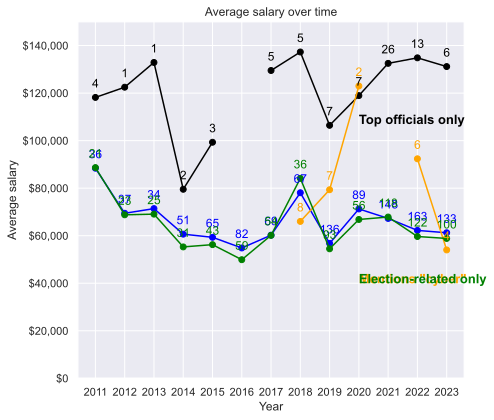

In [69]:
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['figure.dpi'] = 200

# Plot salary over time, split by top official

salary_means = job_df.groupby('Year')['salary_mean'].mean()
year_counts = job_df.groupby('Year').size()

# Plot
plt.figure(figsize=(7,6))
salary_means.plot(kind='line', marker='o', color='blue')
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')


def plot_subset(df, color='black', salary_col='salary_mean'):
    salary_means = df.groupby('Year')['salary_mean'].mean()
    year_counts = df.groupby('Year').size()
    
    # Plot
    salary_means.plot(kind='line', marker='o', color=color)
    for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
        plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center',
                     color=color)
    
color='black'
plot_subset(job_df.loc[job_df['is_top_official']], color=color)
plt.annotate('Top officials only', (2020, 107000), weight=800, size=13, color=color)

color='orange'
plot_subset(job_df.loc[job_df['mentions_cyber']], color=color)
plt.annotate('Mentions "cyber"', (2020, 40000), weight=800, size=13, color=color)

color='green'
plot_subset(job_df.loc[job_df['election_related_only']], color=color)
plt.annotate('Election-related only', (2020, 40000), weight=800, size=13, color=color)


# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))


plt.title('Average salary over time')
plt.ylabel('Average salary')
plt.xlabel('Year')
plt.ylim([0, 150000])
plt.grid(True)

plt.tight_layout()
plt.xticks(range(2011, 2024));
plt.show()


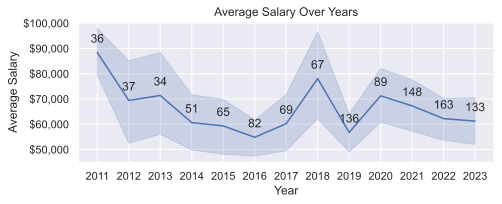

In [6]:
# with error bars

plt.figure(figsize=(7,3))
sns.lineplot(data=job_df, x="Year", y="salary_mean") # for error bar

plt.title('Average Salary Over Years')
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.grid(True)

# Annotate each point with the number of rows (job listings) for the year
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.xticks(range(2011, 2024));

# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.show()


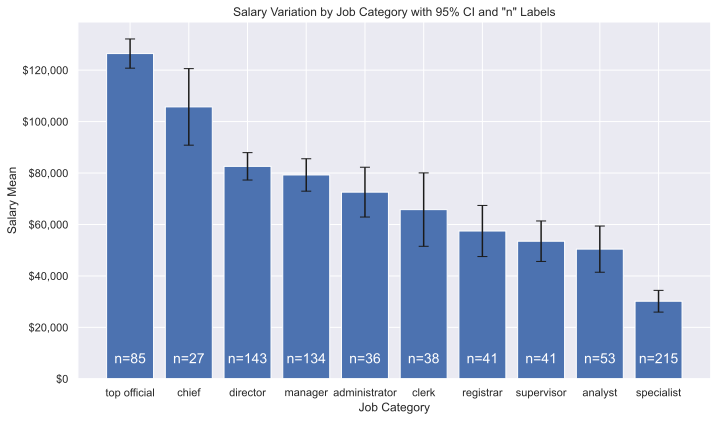

In [7]:
top_official = 'top official'
titles = ['chief', 'director', 'manager', 'administrator', 'clerk', 'registrar', 'supervisor', 'analyst', 'specialist']
for title in titles[::-1]: # reverse to prioritize catching the higher level jobs:
    job_df.loc[job_df['job_title_sg'].str.lower().str.contains(title, na=False), 'seniority'] = title
job_df.loc[job_df['is_top_official'], 'seniority'] = top_official
titles = [top_official] + titles

    

category_order = pd.CategoricalDtype(categories=titles, ordered=True)
job_df['seniority'] = job_df['seniority'].astype(category_order)

# Group the data by 'Category' and calculate the mean and standard deviation of salaries
grouped_data = job_df.groupby('seniority', observed=True)['salary_mean'].agg(['mean', 'size', 'std']).reset_index()

grouped_data['ci'] = grouped_data.apply(lambda row: sps.t.interval(0.95, row['size'] - 1, loc=row['mean'], scale=row['std'] / (row['size'] ** 0.5)), axis=1)

# Extract lower and upper CI bounds
grouped_data['ci_lower'] = grouped_data['ci'].apply(lambda x: x[0])
grouped_data['ci_upper'] = grouped_data['ci'].apply(lambda x: x[1])


# Create the bar chart with 95% CI error bars and "n" labels
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_data['seniority'], grouped_data['mean'], yerr=[grouped_data['mean'] - grouped_data['ci_lower'], grouped_data['ci_upper'] - grouped_data['mean']], capsize=5)

# Add "n" labels on top of each bar
for bar, n in zip(bars, grouped_data['size']):
    plt.text(bar.get_x() + bar.get_width() / 2, 5000, f'n={n}', ha='center', va='bottom', fontsize=14, color='w')

plt.xlabel('Job Category')
plt.ylabel('Salary Mean')
plt.title('Salary Variation by Job Category with 95% CI and "n" Labels')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.show()


# Part E: Download HTML from OpenTheBooks

In [11]:
# load in excel doc
state = pd.read_excel('/Users/will/Repos/election-jobs/State Election Offices.xlsx')


# the above file was previously processed from  just the State and Employer columns (provided by Grace)
# using the below code.
# and then i made some manual changes to DC and TN div of elections
# Function to format office name
# def format_office_name(office_name):
#     # Use urllib.parse.quote to URL encode the office name
#     return quote(office_name)

# # Construct the URLs for each row in the DataFrame
# base_url = 'https://www.openthebooks.com/'
# urls = []

# for index, row in df.iterrows():
#     state_name = row['State'].lower().replace(' ', '-')
#     office_name = quote(row['Employer'])
#     url = f'{base_url}{state_name}-state-employees/?Year_S=0&Emp_S={office_name}'
#     urls.append(url)


In [18]:
# download a whole bunch of pages from OTB

# exclude=['California', 'District of Columbia', 'Hawaii', 'Indiana'] # delaware was partially excluded.
df_continue = state.loc[i+1:]
for i, row in tqdm(df_continue.iterrows(), total=df_continue.shape[0]):
    if row['State'] not in exclude:
        dir_path = f"openthebooks/{row['State']}"
        os.makedirs(dir_path, exist_ok=True)
        
        # Send an HTTP GET request with headers
        response = requests.get(row['URL'], headers=headers)
    
        filename = f"{''.join(urlparse(row['URL'])[2:]).replace('/', '|')}.html"
    
        soup = BeautifulSoup(response.text, 'html.parser')
        with open(f"{dir_path}/{filename}", 'w') as f:
            f.write(response.text)
        
        while soup.find('li', class_='pg-next'): # while there are more pages
            next_link = soup.find('li', class_='pg-next').a['href']
            next_url = urljoin(base_url, soup.find('li', class_='pg-next').a['href'])
    
            response = requests.get(next_url, headers=headers)
            filename = f"{''.join(urlparse(next_url)[2:]).replace('/', '|')}.html"
            
            soup = BeautifulSoup(response.text, 'html.parser')
            
            with open(f"{dir_path}/{filename}", 'w') as f:
                f.write(response.text)
        


    # soup = BeautifulSoup(response.text, 'html.parser')
    
    # weeks = soup.find('ul', class_='weeks').find_all('li')
    # weeks = [f"{base_url}{week.find('a')['href']}" for week in weeks]


  2%|▋                                           | 1/62 [00:00<00:45,  1.33it/s]


KeyboardInterrupt: 

Read in the OTB data

In [118]:
all_df = pd.DataFrame()

otb = 'openthebooks'
states = sorted(os.listdir(otb))
if '.DS_Store' in states:
    states.remove('.DS_Store')
# state_dirs = [os.path.join(otb, dir) for dir in state_dirs]

for state in states:
    files = [os.path.join(otb, state, file) for file in os.listdir(os.path.join(otb, state))]
    for file in files:
        with open(file) as f:
            text = io.StringIO(f.read())
        df = pd.read_html(text)[0]
        df['State'] = state
        if len(df) == 0:
            print(f"{state} has len 0")
        all_df = pd.concat([all_df, df])

all_df['Annual Wages'] = pd.to_numeric(all_df['Annual Wages'].str.replace('[\$,]', '', regex=True))


In [144]:
# for demo purposes
filt = elections[['State', 'Employer', 'Title', 'Annual Wages', 'Year', 'Source']].sample(10)
filt[filt['Title'].notna()].reset_index(drop=True).sort_values('State')

,State,Employer,Title,Annual Wages,Year,Source
3,Colorado,Department of State,Elections Specialist V,91584.00,2019,Colorado Department of Personnel & Administration
2,Louisiana,Louisiana Secretary of State,Election Technician Supv,49507.96,2022,Department of Administrative Services
6,Louisiana,Louisiana Secretary of State,Election Machine Mechanic,22707.50,2017,Department of Administrative Services
1,North Carolina,North Carolina State Board of Elections,Professionals,52205.50,2018,North Carolina Department of State Treasurer
5,South Carolina,South Carolina State Election Commission,Attorney Iii,74250.00,2019,South Carolina Department of Administration
4,Wisconsin,Wisconsin Elections Commission,Elections Specialist-Entry,54969.33,2019,Wisconsin Department of Administration
0,Wyoming,Secretary of State,Elections Director,99661.77,2019,Wyoming State Auditor


In [147]:
elections['Year'].unique()

array([2020, 2018, 2022, 2021, 2019, 2017, 2023])

In [145]:
len(elections)

6126

In [156]:
sum(elections['Annual Wages'].notna())

6126

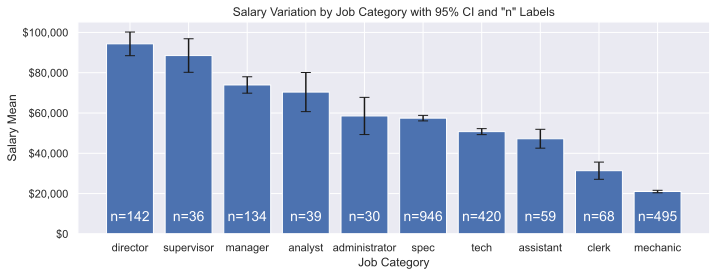

In [119]:
elections = all_df[all_df['Employer'].str.contains('election', case=False) | all_df['Title'].str.contains('election', case=False)]
elections = elections[elections['Annual Wages'] > 10000] # filter out people who are probably not FTEs

titles = ['director', 'supervisor', 'manager', 'analyst', 'administrator', 'spec', 'tech',  'assistant', 'clerk', 'mechanic']
for title in titles[::-1]: # reverse to prioritize catching the higher level jobs
    elections.loc[elections['Title'].str.lower().str.contains(title, na=False), 'seniority'] = title

category_order = pd.CategoricalDtype(categories=titles, ordered=True)
elections['seniority'] = elections['seniority'].astype(category_order)

# Group the data by 'Category' and calculate the mean and standard deviation of salaries
grouped_data = elections.groupby('seniority', observed=True)['Annual Wages'].agg(['mean', 'size', 'std']).reset_index()

grouped_data['ci'] = grouped_data.apply(lambda row: sps.t.interval(0.95, row['size'] - 1, loc=row['mean'], scale=row['std'] / (row['size'] ** 0.5)), axis=1)

# Extract lower and upper CI bounds
grouped_data['ci_lower'] = grouped_data['ci'].apply(lambda x: x[0])
grouped_data['ci_upper'] = grouped_data['ci'].apply(lambda x: x[1])


# Create the bar chart with 95% CI error bars and "n" labels
plt.figure(figsize=(10, 4))
bars = plt.bar(grouped_data['seniority'], grouped_data['mean'], yerr=[grouped_data['mean'] - grouped_data['ci_lower'], grouped_data['ci_upper'] - grouped_data['mean']], capsize=5)

# Add "n" labels on top of each bar
for bar, n in zip(bars, grouped_data['size']):
    plt.text(bar.get_x() + bar.get_width() / 2, 5000, f'n={n}', ha='center', va='bottom', fontsize=14, color='w')

plt.xlabel('Job Category')
plt.ylabel('Salary Mean')
plt.title('Salary Variation by Job Category with 95% CI and "n" Labels')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.show()

In [173]:
elections['State'].value_counts()

State
Maryland          1413
Louisiana         1071
New York           523
North Carolina     503
Illinois           452
Virginia           329
Delaware           237
Connecticut        231
Wisconsin          203
Oklahoma           179
Alaska             130
Rhode Island       106
Colorado           104
South Carolina      85
Arkansas            79
Kentucky            74
Ohio                55
Arizona             51
New Jersey          50
Missouri            48
Maine               44
Massachusetts       41
Nebraska            17
New Hampshire       16
Vermont             16
Washington          15
Pennsylvania        13
Florida              8
Nevada               7
Idaho                7
Wyoming              6
Utah                 5
Tennessee            4
Kansas               4
Name: count, dtype: int64

In [179]:
elections['Year'].value_counts()

Year
2022    1155
2021    1092
2020    1083
2019    1049
2017     928
2018     792
2023      27
Name: count, dtype: int64

In [181]:
len(elections)

6126

In [176]:
job_df['state_full_name_sg'].value_counts()

state_full_name_sg
North Carolina                                                                    105
California                                                                        100
Colorado                                                                           90
Virginia                                                                           78
Washington                                                                         69
Arizona                                                                            56
Washington, D.C.                                                                   46
Florida                                                                            46
Oregon                                                                             41
Texas                                                                              32
Michigan                                                                           31
Maryland                           

In [14]:
elections.loc[elections['Title'].str.lower().str.contains('tech', na=False)]

,Year,Employer,Name,Title,Annual Wages,Source,State,seniority
5,2021,Connecticut State Elections Enforcement Commis...,Bramande Richard J,Dptechlanlyst4rc,123077.25,Office of the State Comptroller,Connecticut,tech
6,2021,Connecticut State Elections Enforcement Commis...,Frost Douglas A,Informationtechnologymanager1,123045.20,Office of the State Comptroller,Connecticut,manager
7,2020,Connecticut State Elections Enforcement Commis...,Frost Douglas A,Informationtechnologymanager1,122789.33,Office of the State Comptroller,Connecticut,manager
13,2019,Connecticut State Elections Enforcement Commis...,Frost Douglas A,Informationtechnologymanager1,118887.19,Office of the State Comptroller,Connecticut,manager
17,2018,Connecticut State Elections Enforcement Commis...,Frost Douglas A,Informationtechnologymanager1,118787.24,Office of the State Comptroller,Connecticut,manager
26,2020,Connecticut State Elections Enforcement Commis...,Bramande Richard J,Dptechlanlyst4rc,115233.97,Office of the State Comptroller,Connecticut,tech
32,2019,Connecticut State Elections Enforcement Commis...,Bramande Richard J,Dptechlanlyst4rc,113428.80,Office of the State Comptroller,Connecticut,tech
63,2018,Connecticut State Elections Enforcement Commis...,Bramande Richard J,Dptechlanlyst4rc,102011.78,Office of the State Comptroller,Connecticut,tech
23,2022,Connecticut State Elections Enforcement Commis...,Frost Douglas A,Informationtechnologymanager1,72739.61,Office of the State Comptroller,Connecticut,manager
49,2022,Connecticut State Elections Enforcement Commis...,Bramande Richard J,Dptechlanlyst4rc,64891.40,Office of the State Comptroller,Connecticut,tech


In [15]:
# find the 20 most common words in the titles

# Assuming 'elections' is your DataFrame
word_counts = Counter(' '.join([str(title) for title in elections['Title']]).split())
most_common_words = word_counts.most_common(20)

# Display the 20 most common words
print(most_common_words)


[('nan', 2189), ('Election', 1385), ('Machine', 507), ('Mechanic', 495), ('Specialist', 494), ('Elections', 442), ('Technician', 372), ('Professionals', 268), ('Program', 242), ('Spec', 208), ('Ii', 197), ('C', 183), ('Administrative', 161), ('Speciali', 148), ('I', 142), ('Director', 139), ('Supv', 132), ('Information', 126), ('Manager', 125), ('Info', 124)]
